## Import Statements & df, train, test set construction

In [18]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import make_pipeline

In [10]:
# Read the Flights csv. Remove all cancellation and diverted data and focus only on Boston for EDA
# Files are zipped to comply with github filesize requirements
if(os.path.isfile('../Data/Boston_Flights_Model.csv')):
    df = pd.read_csv('../Data/Boston_Flights_Model.csv')
else:
    df = pd.read_csv('../Data/flights.csv')
    df = df[df['ORIGIN_AIRPORT'] == 'BOS']
    df = df[df['CANCELLED'] == 0]
    df = df[df['DIVERTED'] == 0]
    df = df.drop(['CANCELLED', 'DIVERTED', 'CANCELLATION_REASON', 'YEAR', 'ORIGIN_AIRPORT'], axis = 1)
    df = df.drop(['DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'ELAPSED_TIME', 'AIR_TIME', 'WHEELS_ON', 'TAXI_IN', 'ARRIVAL_TIME',
             'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'TAIL_NUMBER'], axis=1)
    df.to_csv('../Data/Boston_Flights_Model.csv')

In [11]:
# Split in X and y
y = df['ARRIVAL_DELAY']
X = df.drop(['ARRIVAL_DELAY'], axis=1)

In [12]:
# Convert times in hours. Previously they were on 60 minute scale, so preprocessing would not work
X['SCHEDULED_DEPARTURE'] = X['SCHEDULED_DEPARTURE']/60
X['SCHEDULED_ARRIVAL'] = X['SCHEDULED_ARRIVAL']/60

## CV Pipeline & Preprocessing

In [56]:
# ML Pipeline where 5% worth of data is taken out as test data
# Returns the scores over the 10 tests, the true labels, pred labels, best models, and best parameters
def MLpipe_TSS_MSE_TEST(X, y, preprocessor, ML_algo, param_grid):
    random_states = 1
    n_splits = 5
    splits = [0.5, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95]
    diff = 0.05
    
    scores = []
    true = []
    pred = []
    best_models = []
    best_params = []
    
    for i in splits:
        start = int(X.shape[0]*i)
        end = int(X.shape[0]*(i+diff))
        X_other = X[0: start]
        X_test = X[start:end-1]
        y_other = y[0:start]
        y_test = y[start:end-1]
        
        tscv = TimeSeriesSplit(n_splits=n_splits)
        pipe = make_pipeline(preprocessor, ML_algo)
        grid = GridSearchCV(pipe, param_grid = param_grid, scoring='neg_mean_squared_error', cv=tscv, return_train_score = True,
                            n_jobs = -1, verbose=False)
        
        grid.fit(X_other, y_other)
        y_pred = grid.predict(X_test)
        score = mean_squared_error(y_test, y_pred)
        
        scores.append(score)
        true.append(y_test)
        pred.append(y_pred)
        best_models.append(grid)
        best_params.append(grid.best_params_)
        
    return scores, true, pred, best_models, best_params

In [21]:
# Cell to encode data use onehot, minmax, and standard
onehot_ftrs = ['AIRLINE', 'DESTINATION_AIRPORT']
minmax_ftrs = ['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL', 'SCHEDULED_TIME', 'MONTH', 'DAY', 'DAY_OF_WEEK']
std_ftrs = ['DISTANCE', 'FLIGHT_NUMBER']

# collect all the encoders
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), onehot_ftrs),
        ('minmax', MinMaxScaler(), minmax_ftrs),
        ('std', StandardScaler(), std_ftrs)])

## Models

In [24]:
# test your function with a linear regression model (l1 regularization)
from sklearn.linear_model import Lasso
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV

param_grid = {
    'lasso__alpha': np.logspace(-2, 2, 21)  # we use logspace since values can go up to inf
}
print("Linear Regression w/ l1")
# MLpipe_TSS_MSE(X, y, preprocessor, Lasso(), param_grid)
l1_scores, l1_true, l1_pred, l1_best_models, l1_best_params = MLpipe_TSS_MSE_TEST(X, y, preprocessor, Lasso(max_iter=10000), param_grid)
print(l1_scores)

Linear Regression w/ l1
[1466.5067691753368, 1371.1812120997024, 1487.9810321880761, 2011.2451941589654, 1201.1256596730889, 1074.1703000059804, 811.223342134589, 1074.8369449575778, 906.3608268559883, 3832.3786879738336]


In [25]:
# For ridge regurlization, I went up to 100 since I saw that alpha can be any value from 0 - inf
from sklearn.linear_model import Ridge
param_grid = {
    'ridge__alpha': np.logspace(-2, 2, 21) # we use logspace since values can go up to inf
}
print("Linear Regression w/ l2")
# MLpipe_TSS_MSE(X, y, preprocessor, Ridge(), param_grid)
l2_scores, l2_true, l2_pred, l2_best_models, l2_best_params = MLpipe_TSS_MSE_TEST(X, y, preprocessor, Ridge(), param_grid)
print(l2_scores)

Linear Regression w/ l2
[1508.3762251022458, 1327.728753200796, 1421.1197218000955, 1994.234977184959, 1133.6764301004396, 1003.5243715294225, 741.1826040252462, 963.3602200339949, 772.7148439762477, 4146.076724222078]


In [26]:
from sklearn.linear_model import ElasticNet
param_grid = {
    'elasticnet__alpha': 1/np.logspace(-2, 2, 5),
    'elasticnet__l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
}
print("Linear Regression w/ Elastic Net")
# MLpipe_TSS_MSE(X, y, preprocessor, ElasticNet(max_iter=10000), param_grid)
en_scores, en_true, en_pred, en_best_models, en_best_params = MLpipe_TSS_MSE_TEST(X, y, preprocessor, ElasticNet(max_iter=5000), param_grid)
print(en_scores)

Linear Regression w/ Elastic Net
[1476.4281286384728, 1359.5120346160752, 1480.351765485026, 2029.3401817803274, 1201.1256596730889, 1074.1703000059804, 811.223342134589, 1074.8369449575778, 887.2105778920464, 3845.6062398707027]


In [27]:
from sklearn.ensemble import RandomForestRegressor
param_grid = {
        'randomforestregressor__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9], # the max_depth should be smaller or equal than the number of features roughly
        'randomforestregressor__max_features': [0.5,0.75,1.0] # linearly spaced between 0.5 and 1
} 
print("RF")
# MLpipe_TSS_MSE(X, y, preprocessor, RandomForestRegressor(), param_grid)
rf_scores, rf_true, rf_pred, rf_best_models, rf_best_params = MLpipe_TSS_MSE_TEST(X, y, preprocessor, RandomForestRegressor(), param_grid)
print(rf_scores)

RF
[1473.2065883315922, 1358.2818899159809, 1435.7361700997667, 2002.9982748345603, 1172.9345253973665, 1058.6659756684016, 798.9415907436753, 1006.7481527284124, 844.5532836730525, 3844.2036022548996]


In [55]:
# # Convergence warning will fix in future
# param_grid = {
#     'mlpregressor__hidden_layer_sizes': [[10], [100, 10, 1], [10, 1]]
# }
# print("MLP")
# mlp_scores, mlp_true, mlp_pred, mlp_best_models, mlp_best_params = MLpipe_TSS_MSE_TEST(X, y, preprocessor, MLPRegressor(shuffle=False, batch_size = 256), param_grid)
# simplefilter("ignore", category=ConvergenceWarning)
# print(mlp_scores)

In [45]:
# Here the prints are just to track how long the model takes, can ignore
import xgboost as xgb
param_grid = {
    'xgbregressor__n_estimators': [10, 100, 1000],
    'xgbregressor__max_depth': [5, 6]
}
xgb_scores, xgb_true, xgb_pred, xgb_best_models, xgb_best_params = MLpipe_TSS_MSE_TEST(X, y, preprocessor, xgboost.XGBRegressor(), param_grid)

0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95


In [57]:
test_scores = []
splits = [0.5, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95]
diff = 0.05
baseline_scores = []
    
for i in splits:
    start = int(X.shape[0]*i)
    end = int(X.shape[0]*(i+diff))
    y_test = y[start:end-1]
    y_baseline = [np.mean(y_test)] * len(y_test)
    baseline_scores.append(mean_squared_error(y_test, y_baseline))
print(baseline_scores)

[1489.0325654920234, 1417.6124638354602, 1487.1960204496493, 2088.723494387626, 1118.160060274751, 993.9260125679484, 727.1413194119704, 984.2139661205268, 784.6367003664975, 3709.6547048540297]


In [113]:
# Pickle all the predictions and models 
import pickle

with open('../results/true.pkl', 'wb') as f:
    pickle.dump(xgb_true, f)

with open('../results/xgb_pred.pkl', 'wb') as f:
    pickle.dump(xgb_pred, f)
with open ('../results/xgb_best_models.pkl', 'wb') as f:
    pickle.dump(xgb_best_models, f)

with open('../results/rf_pred.pkl', 'wb') as f:
    pickle.dump(rf_pred, f)
with open ('../results/xgb_best_models.pkl', 'wb') as f:
    pickle.dump(rf_best_models, f)

with open('../results/en_pred.pkl', 'wb') as f:
    pickle.dump(en_pred, f)
with open ('../results/en_best_models.pkl', 'wb') as f:
    pickle.dump(en_best_models, f)

with open('../results/l2_pred.pkl', 'wb') as f:
    pickle.dump(l2_pred, f)
with open ('../results/l2_best_models.pkl', 'wb') as f:
    pickle.dump(l2_best_models, f)

with open('../results/l1_pred.pkl', 'wb') as f:
    pickle.dump(l1_pred, f)
with open ('../results/l1_best_models.pkl', 'wb') as f:
    pickle.dump(l1_best_models, f)

## Models Graphical Analysis

In [59]:
# Print the mean and std of the models
print('RF:', np.mean(rf_scores), np.std(rf_scores))
print('L1:', np.mean(l1_scores), np.std(l1_scores))
print('L2:', np.mean(l2_scores), np.std(l2_scores))
print('EN:', np.mean(en_scores), np.std(en_scores))
print('XGB:', np.mean(xgb_scores), np.std(xgb_scores))
print('Baseline:', np.mean(baseline_scores), np.std(baseline_scores))


RF: 1499.6270053647709 850.844661099126
L1: 1523.7009969223138 836.1726097353169
L2: 1501.1994871175525 951.5963585962587
EN: 1523.9805175053887 842.5165963569851
XGB: 1521.4206905862375 909.1773611322934
Baseline: 1480.0297307760484 837.2130032028115


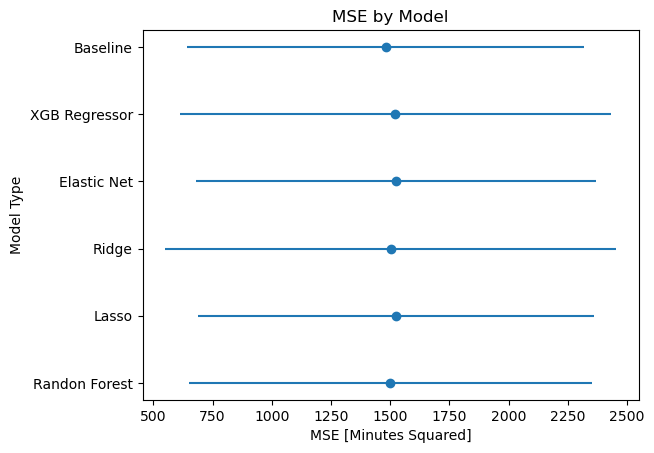

In [60]:
# Plot of mean & Std of MSE of the models
y_plot = ['Randon Forest', 'Lasso', 'Ridge', 'Elastic Net', 'XGB Regressor', 'Baseline']
x_plot = [np.mean(rf_scores), np.mean(l1_scores), np.mean(l2_scores), np.mean(en_scores), np.mean(xgb_scores), np.mean(baseline_scores)]
x_err = [np.std(rf_scores), np.std(l1_scores), np.std(l2_scores), np.std(en_scores), np.std(xgb_scores), np.std(baseline_scores)]
plt.errorbar(x_plot, y_plot, xerr = x_err, fmt='o')
plt.xlabel('MSE [Minutes Squared]')
plt.ylabel('Model Type')
plt.title('MSE by Model')
plt.savefig('../figures/MSE_Mean_Std', dpi=300, bbox_inches="tight")
plt.show()


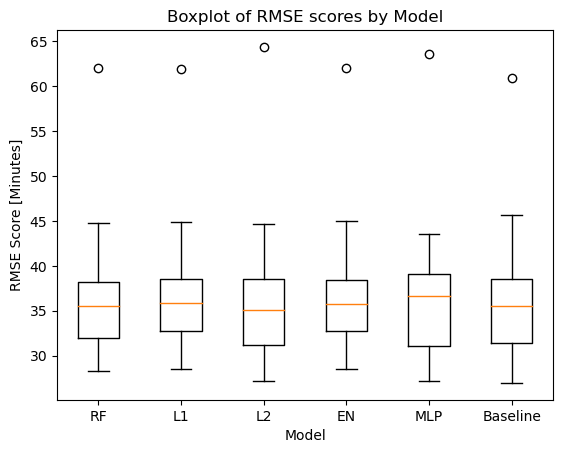

In [65]:
# Plot of RMSE of the models
x = ['RF', 'L1', 'L2', 'EN', 'MLP', 'Baseline']
y_labels = [np.sqrt(rf_scores), np.sqrt(l1_scores), np.sqrt(l2_scores), np.sqrt(en_scores), np.sqrt(xgb_scores), np.sqrt(baseline_scores)]
plt.boxplot(y_labels, labels=x)
plt.ylabel('RMSE Score [Minutes]')
plt.xlabel("Model")
plt.title("Boxplot of RMSE scores by Model")
plt.savefig('../figures/BoxPlot_RMSE', dpi=300, bbox_inches="tight")
plt.show()

In [67]:
print(l2_best_params)

[{'ridge__alpha': 100.0}, {'ridge__alpha': 100.0}, {'ridge__alpha': 100.0}, {'ridge__alpha': 100.0}, {'ridge__alpha': 100.0}, {'ridge__alpha': 100.0}, {'ridge__alpha': 100.0}, {'ridge__alpha': 100.0}, {'ridge__alpha': 100.0}, {'ridge__alpha': 100.0}]


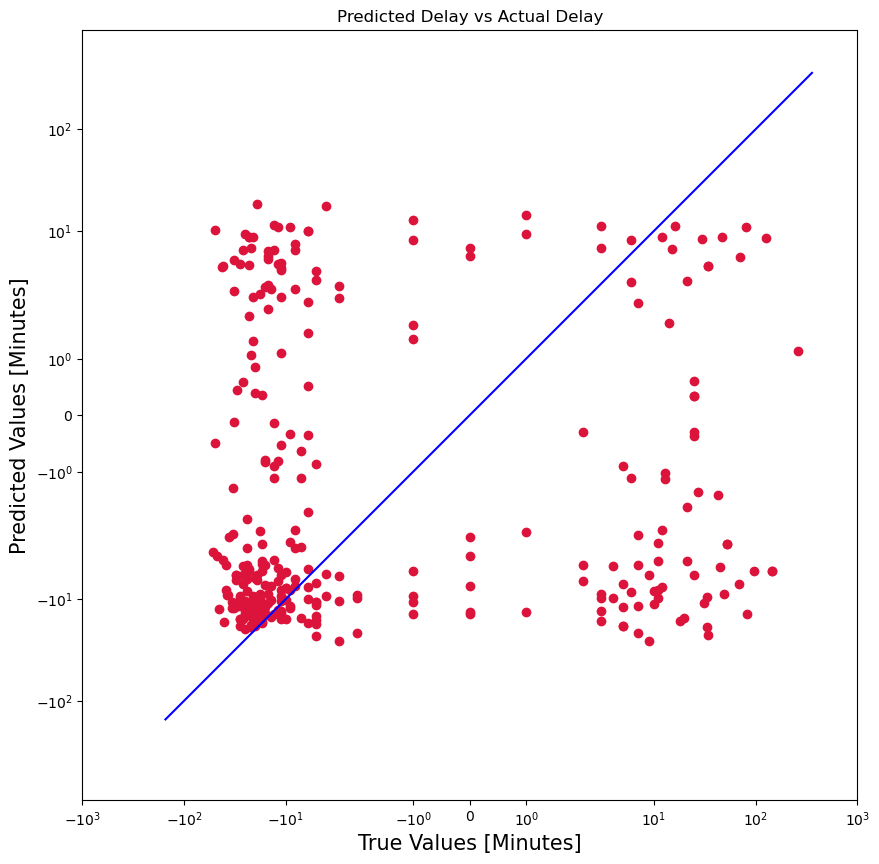

In [69]:
# Show predicted vs true points of 300 randomly selected points from test set 8
from numpy import random
random.seed(1)
rand = random.randint(0, len(l2_pred[8]),300)
random_seed = 1
predicted_value = []
true_value = []
for i in rand:
    predicted_value.append(l2_pred[8][i])
    true_value.append(list(l2_true[8])[i])
plt.figure(figsize=(10,10))
plt.scatter(true_value, predicted_value, c='crimson')
plt.yscale('symlog')
plt.xscale('symlog')

p1 = max(max(predicted_value), max(true_value)) + 100
p2 = min(min(predicted_value), min(true_value)) - 100
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values [Minutes]', fontsize=15)
plt.ylabel('Predicted Values [Minutes]', fontsize=15)
plt.axis('equal')
plt.xlim([-1000, 1000])
plt.ylim([-1000, 1000])
plt.title("Predicted Delay vs Actual Delay")
plt.savefig('../figures/PredActual_Ridge', dpi=300, bbox_inches="tight")
plt.show()

## XGB Classification Exploration

In [106]:
# Flights classified as delayed if 15 minutes or mroe late
y_classifier = []
for i in y:
    if (i >= 15):
        y_classifier.append(1)
    else:
        y_classifier.append(0)

In [143]:
from sklearn.metrics import accuracy_score
def MLpipe_TSS_Classifier(X, y, preprocessor, ML_algo, param_grid):
    random_states = 1
    n_splits = 5
    test_scores = []
    splits = [0.5, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95]
    diff = 0.05
    scores = []
    true = []
    pred = []
    
    for i in splits:
        start = int(X.shape[0]*i)
        end = int(X.shape[0]*(i+diff))
        X_other = X[0: start]
        X_test = X[start:end-1]
        y_other = y[0:start]
        y_test = y[start:end-1]
        
        tscv = TimeSeriesSplit(n_splits=n_splits)
        pipe = make_pipeline(preprocessor, ML_algo)
        grid = GridSearchCV(pipe, param_grid = param_grid, scoring='accuracy', cv=tscv, return_train_score = True,
                            n_jobs = -1, verbose=False)
        grid.fit(X_other, y_other)
        y_pred = grid.predict(X_test)
        score = accuracy_score(y_test, y_pred)
        scores.append(score)
        true.append(y_test)
        pred.append(y_pred)
    return scores, true, pred, grid.best_params_

In [156]:
import xgboost as xgb
param_grid = {
    'xgbclassifier__n_estimators': [550, 600, 650],
    'xgbclassifier__max_depth': [2],
}
print("XGB Classifier")
xgb_scores, xgb_true, xgb_pred, xgb_params = MLpipe_TSS_Classifier(X, y_classifier, preprocessor, xgb.XGBClassifier(), param_grid)
print(xgb_scores)

XGB Classifier
[0.7377862595419847, 0.7568702290076336, 0.7904580152671755, 0.7954198473282442, 0.8112955542835337, 0.874236641221374, 0.8778625954198473, 0.8704198473282443, 0.8732824427480916]


In [157]:
print(xgb_params)

{'xgbclassifier__max_depth': 2, 'xgbclassifier__n_estimators': 550}


In [127]:
# Calculate the baseliene accuracy
from collections import Counter
splits = [0.5, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95]
diff = 0.05
baseline_scores_class = []
    
for i in splits:
    start = int(X.shape[0]*i)
    end = int(X.shape[0]*(i+diff))
    y_true = y_classifier[start:end]
    c = Counter(y_true)
    baseline_scores_class.append(c[0]/len(y_true))


In [158]:
print("XGB Classifier:", np.mean(xgb_scores))
print("Baseline:", np.mean(baseline_scores_class))

XGB Classifier: 0.8208479369051255
Baseline: 0.8332937121174973


## SHAP Analysis

In [70]:
# Shap Analysis
start = int(X.shape[0]*0.95)
end = X.shape[0]-1
X_train = X[0:start]
y_train = y[0:start]
X_test = X[start:end]
y_test = y[start:end]

In [71]:
X_prep = preprocessor.fit_transform(X_train)
feature_names = preprocessor.get_feature_names_out()
df_train = pd.DataFrame(data=X_prep.toarray(), columns = feature_names)


# transform the test
X_test = pd.DataFrame(data=X_test,columns = X.columns)
df_test = preprocessor.transform(X_test)
df_test = pd.DataFrame(data=df_test.toarray(), columns = feature_names)
print(f'preprocessed test size: {df_test.shape}')

preprocessed test size: (5240, 81)


In [72]:
final_model = Ridge(alpha=100)
final_model.fit(X_prep, y_train)

Ridge(alpha=100)

In [73]:
import shap
shap.initjs() # required for visualizations later on
# create the explainer object with the random forest model
explainer = shap.LinearExplainer(final_model, df_train)
# transform the test set
# calculate shap values on the first 1000 points in the test
shap_values = explainer.shap_values(df_test)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [106]:
index1 = 205
shap.force_plot(explainer.expected_value, shap_values[index1,:], features = df_test.iloc[index1],feature_names = feature_names)


In [107]:
index1 = 100
shap.force_plot(explainer.expected_value, shap_values[index1,:], features = df_test.iloc[index1],feature_names = feature_names)

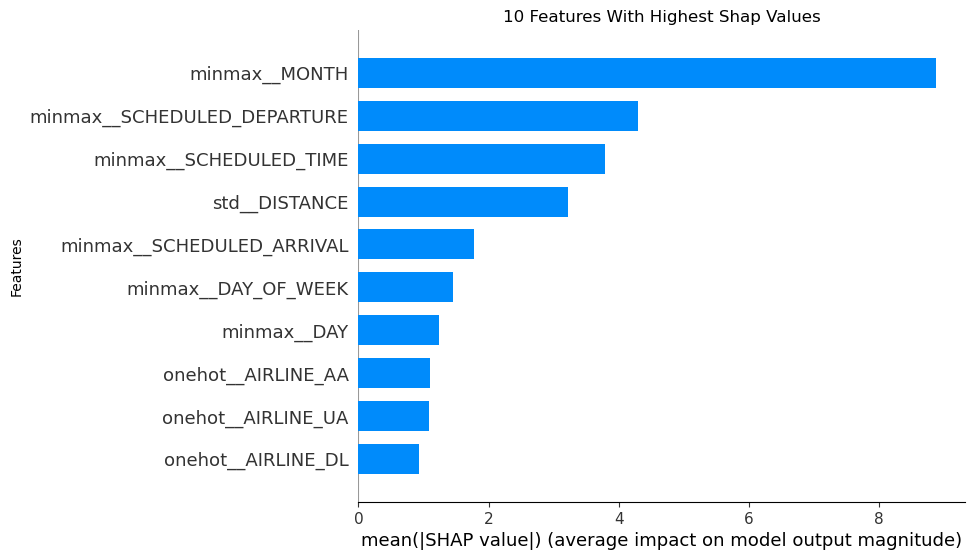

In [76]:
fig = shap.summary_plot(shap_values, df_test, feature_names = feature_names, max_display = 10, plot_type = 'bar', show = False) # change to False if want to save fig
_, h = plt.gcf().get_size_inches()
plt.gcf().set_size_inches(h*2, h)
plt.ylabel('Features')
plt.title('10 Features With Highest Shap Values')
plt.savefig('../figures/Shap_Global', dpi=300, bbox_inches="tight")
plt.show()

## Estimating Arrival Delay at Time of Departure

In [ ]:
# We also need to remove features we will not have access to ahead of the day of departure
# May be used for outlook
df_outlook = df.drop(['DEPARTURE_TIME', 'TAXI_OUT', 'WHEELS_OFF', 'ELAPSED_TIME', 'AIR_TIME', 'WHEELS_ON', 'TAXI_IN', 'ARRIVAL_TIME',
             'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'TAIL_NUMBER'], axis=1)

In [251]:
y_outlook = df_outlook['ARRIVAL_DELAY']
X_outlook = df_outlook.drop(['ARRIVAL_DELAY'], axis=1)
X_outlook['SCHEDULED_DEPARTURE'] = X_outlook['SCHEDULED_DEPARTURE']/60
X_outlook['SCHEDULED_ARRIVAL'] = X_outlook['SCHEDULED_ARRIVAL']/60
# For ridge regurlization, I went up to 100 since I saw that alpha can be any value from 0 - inf
from sklearn.linear_model import Ridge
param_grid = {
    'ridge__alpha': np.logspace(-2, 2, 21) # we use logspace since values can go up to inf
}
print("Linear Regression w/ l2")
# MLpipe_TSS_MSE(X, y, preprocessor, Ridge(), param_grid)
l2_scores_ol, l2_true_ol, l2_pred_ol, l2_params_ol = MLpipe_TSS_MSE_TEST(X_outlook, y_outlook, preprocessor, Ridge(), param_grid)
print(l2_scores_ol)

Linear Regression w/ l2
[239.31049398583767, 179.4782362805807, 191.04242875963112, 190.1278664049822, 180.26713224196888, 170.12667472696506, 170.4145332136447, 184.39123462547226, 204.5083494322109]


In [359]:
# Shap Analysis
start = int(X.shape[0]*0.95)
end = X.shape[0]-1
X_train_ol = X_outlook[0:start]
y_train_ol = y_outlook[0:start]
X_test_ol = X_outlook[start:end]
y_test_ol = y_outlook[start:end]

In [360]:
X_prep_ol = preprocessor.fit_transform(X_train_ol)
feature_names = preprocessor.get_feature_names_out()
df_train_ol = pd.DataFrame(data=X_prep_ol.toarray(), columns = feature_names)


# transform the test
X_test_ol = pd.DataFrame(data=X_test_ol,columns = X_outlook.columns)
df_test_ol = preprocessor.transform(X_test_ol)
df_test_ol = pd.DataFrame(data=df_test_ol.toarray(), columns = feature_names)
print(f'preprocessed test size: {df_test_ol.shape}')

preprocessed test size: (5240, 82)


In [361]:
final_model_ol = Ridge(alpha=100)
final_model_ol.fit(X_prep_ol, y_train)

Ridge(alpha=100)

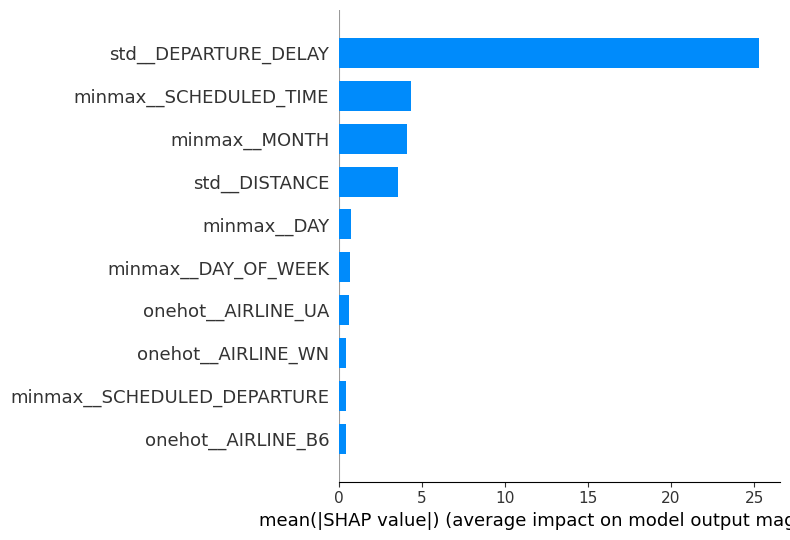

In [363]:
import shap
shap.initjs() # required for visualizations later on
# create the explainer object with the random forest model
explainer_ol = shap.LinearExplainer(final_model_ol, df_train_ol)
# transform the test set
# calculate shap values on the first 1000 points in the test
shap_values_ol = explainer_ol.shap_values(df_test_ol)
shap.summary_plot(shap_values_ol, df_test_ol, feature_names = feature_names, max_display = 10, plot_type = 'bar', show = False) # change to False if want to save fig
# _, h = plt.gcf().get_size_inches()
# plt.gcf().set_size_inches(h*2, h)
# plt.ylabel('Features')
# plt.title('10 Features With Highest Shap Values')
# plt.savefig('Shap', dpi=300, bbox_inches="tight")
# plt.show()